Using device: mps
Training model...
Epoch 1/3 - Loss: 0.3713
Epoch 2/3 - Loss: 0.1134
Epoch 3/3 - Loss: 0.0602

Baseline test accuracy (no masking): 87.70%

L1-norm per FC unit:
Unit 0: 3.239940
Unit 1: 2.548244
Unit 2: 1.838364
Unit 3: 3.529993
Unit 4: 3.244469
Unit 5: 2.000169
Unit 6: 3.411010
Unit 7: 2.286650
Unit 8: 1.946055
Unit 9: 1.830462

Unit ranking (most active to least): [3, 6, 4, 0, 1, 7, 5, 8, 2, 9]

ROF Curve: Activating top-N FC units
Top  1 units activated | Loss: 2.8217 | Acc: 18.30%
Top  2 units activated | Loss:  2.6001 | Acc: 26.80%
Top  3 units activated | Loss: 2.3465 | Acc: 37.40%
Top  4 units activated | Loss: 2.1688 | Acc: 48.20%
Top  5 units activated | Loss: 1.9593 | Acc: 50.00%
Top  6 units activated | Loss: 1.6141 | Acc: 57.40%
Top  7 units activated | Loss: 1.2639 | Acc: 65.10%
Top  8 units activated | Loss: 0.9881 | Acc: 70.90%
Top  9 units activated | Loss: 0.6479 | Acc: 80.10%
Top 10 units activated | Loss: 0.3527 | Acc: 87.70%


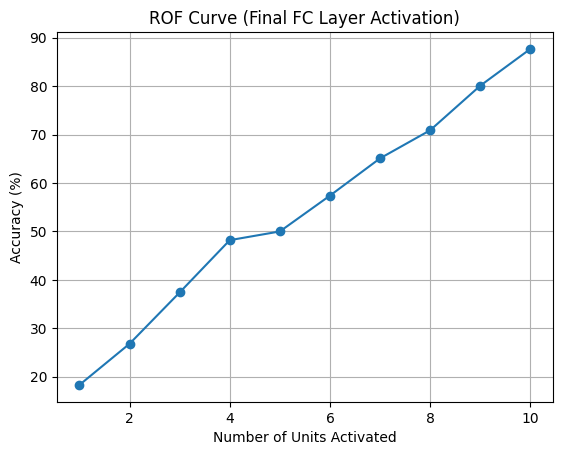

In [59]:
import torc
himport torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

# Use MPS if available, else CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Transform for ResNet18 input (112x112, 3 channels)
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

# Load MNIST train and test sets
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Use subsets for speed
train_subset = Subset(train_dataset, list(range(5000)))  # 5k samples train
test_subset = Subset(test_dataset, list(range(1000)))    # 1k samples test

#train_subset = train_dataset
#test_subset = test_dataset

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_subset, batch_size=128, shuffle=False, num_workers=2)

# Load ResNet18, modify fc layer for MNIST
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)
model.to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Simple training loop for a few epochs
def train_model(model, loader, optimizer, criterion, device, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
        avg_loss = total_loss / len(loader.dataset)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

# Evaluation function
def evaluate_accuracy(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = correct / total
    return acc

print("Training model...")
train_model(model, train_loader, optimizer, criterion, device)

baseline_acc = evaluate_accuracy(model, test_loader, device)
print(f"\nBaseline test accuracy (no masking): {baseline_acc*100:.2f}%")

# --- ROF Test ---

# 1) Collect FC layer outputs to compute L1-norm per unit
fc_outputs = []
def fc_hook(module, input, output):
    fc_outputs.append(output.detach().cpu())

hook_handle = model.fc.register_forward_hook(fc_hook)

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        _ = model(images)

hook_handle.remove()

fc_outputs_tensor = torch.cat(fc_outputs, dim=0)
l1_norms = fc_outputs_tensor.abs().mean(dim=0)
unit_ranking = torch.argsort(l1_norms, descending=True)

print("\nL1-norm per FC unit:")
for i, norm_val in enumerate(l1_norms):
    print(f"Unit {i}: {norm_val:.6f}")

print("\nUnit ranking (most active to least):", unit_ranking.tolist())

# 2) ROF eval: deactivate all FC units, activate top_k units incrementally
def rof_fc_eval(top_k):
    def mask_fc_hook(module, input, output):
        B, D = output.shape
        mask = torch.zeros_like(output)
        for i in range(min(top_k, D)):
            idx = unit_ranking[i]
            mask[:, idx] = 1.0
        return output * mask

    hook = model.fc.register_forward_hook(mask_fc_hook)

    total_correct = 0
    total_samples = 0
    total_loss = 0
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total_loss += loss.item() * labels.size(0)
            total_samples += labels.size(0)

    hook.remove()
    acc = total_correct / total_samples
    avg_loss = total_loss / total_samples
    return avg_loss, acc

print("\nROF Curve: Activating top-N FC units")
E_n = []
for n in range(1, 11):
    loss, acc = rof_fc_eval(n)
    print(f"Top {n:2d} units activated | Loss: {loss:.4f} | Acc: {acc*100:.2f}%")
    E_n.append((n, loss, acc))

# Optional: plot ROF accuracy curve
plt.plot([e[0] for e in E_n], [e[2]*100 for e in E_n], marker='o')
plt.title("ROF Curve (Final FC Layer Activation)")
plt.xlabel("Number of Units Activated")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()



✅ Baseline Accuracy from features (all units active): 87.70%
Top   1 units activated | Acc: 11.30%
Top   2 units activated | Acc: 10.70%
Top   3 units activated | Acc: 10.70%
Top   4 units activated | Acc: 10.70%
Top   5 units activated | Acc: 10.70%
Top   6 units activated | Acc: 10.70%
Top   7 units activated | Acc: 10.70%
Top   8 units activated | Acc: 10.80%
Top   9 units activated | Acc: 10.70%
Top  10 units activated | Acc: 11.00%
Top  50 units activated | Acc: 23.30%
Top 100 units activated | Acc: 25.60%
Top 150 units activated | Acc: 27.80%
Top 200 units activated | Acc: 31.90%
Top 250 units activated | Acc: 40.90%
Top 300 units activated | Acc: 51.10%
Top 350 units activated | Acc: 63.60%
Top 400 units activated | Acc: 73.00%
Top 450 units activated | Acc: 81.80%
Top 500 units activated | Acc: 86.70%
Top 512 units activated | Acc: 87.70%


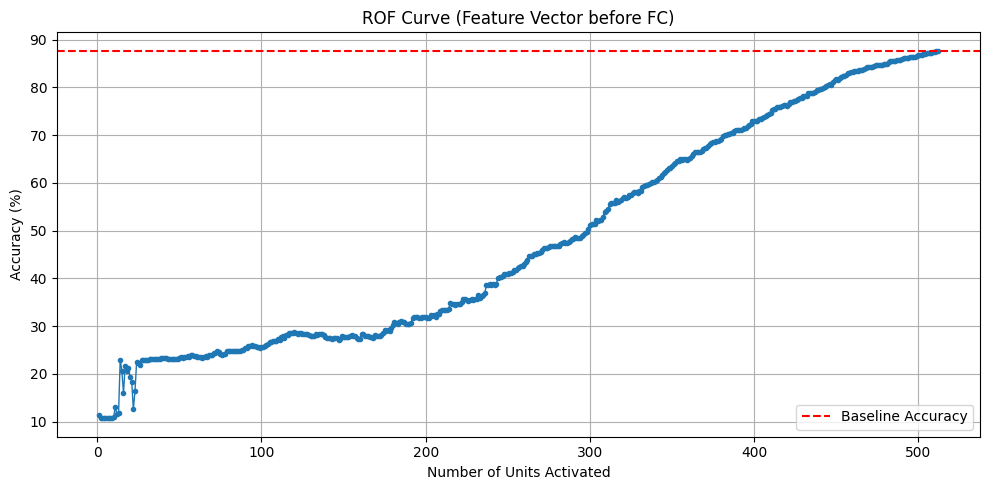

In [61]:
import torch
import matplotlib.pyplot as plt

# ---- Step 1: Extract features (before fc) from entire test set ----
def extract_avgpool_features(model, dataloader, device):
    model.eval()
    feats = []
    labels_all = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            x = model.conv1(images)
            x = model.bn1(x)
            x = model.relu(x)
            x = model.maxpool(x)

            x = model.layer1(x)
            x = model.layer2(x)
            x = model.layer3(x)
            x = model.layer4(x)

            x = model.avgpool(x)  # shape: [B, 512, 1, 1]
            x = torch.flatten(x, 1)  # shape: [B, 512]

            feats.append(x.cpu())
            labels_all.append(labels)

    features = torch.cat(feats, dim=0)       # [N, 512]
    labels = torch.cat(labels_all, dim=0)    # [N]
    return features, labels

features, labels = extract_avgpool_features(model, test_loader, device)

# ---- Step 2: Baseline accuracy from extracted features ----
with torch.no_grad():
    outputs = model.fc(features.to(device))
    preds = outputs.argmax(dim=1)
    base_acc = (preds == labels.to(device)).float().mean().item()
    print(f"\n✅ Baseline Accuracy from features (all units active): {base_acc*100:.2f}%")

# ---- Step 3: Compute L1 norms and unit ranking ----
l1_norms = features.abs().mean(dim=0)
unit_ranking = torch.argsort(l1_norms, descending=True)

# ---- Step 4: ROF evaluation using only top-k units ----
def fast_rof_eval(features, labels, model_fc, unit_ranking, top_k_list, device):
    model_fc = model_fc.to(device)
    labels = labels.to(device)
    all_acc = []

    for k in top_k_list:
        # Create binary mask of top-k units
        mask = torch.zeros(features.shape[1])
        mask[unit_ranking[:k]] = 1.0
        masked_feats = features * mask  # broadcasting

        # Send to device
        masked_feats = masked_feats.to(device)

        with torch.no_grad():
            outputs = model_fc(masked_feats)
            preds = outputs.argmax(dim=1)
            acc = (preds == labels).float().mean().item()
            all_acc.append(acc)

        if k % 50 == 0 or k <= 10 or k == 512:
            print(f"Top {k:3d} units activated | Acc: {acc*100:.2f}%")

    return all_acc

# ---- Step 5: Run ROF for all 512 units ----
top_k_list = list(range(1, 513))
acc_curve = fast_rof_eval(features, labels, model.fc, unit_ranking, top_k_list, device)

# ---- Step 6: Plot ROF curve ----
plt.figure(figsize=(10, 5))
plt.plot(top_k_list, [a * 100 for a in acc_curve], marker='.', linewidth=1)
plt.axhline(base_acc * 100, color='r', linestyle='--', label='Baseline Accuracy')
plt.title("ROF Curve (Feature Vector before FC)")
plt.xlabel("Number of Units Activated")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Feature shape: torch.Size([1000, 512])
Labels shape: torch.Size([1000])

✅ Baseline Accuracy (all units active): 91.50%
Top   1 units activated | Acc: 12.60%
Top   2 units activated | Acc: 10.50%
Top   3 units activated | Acc: 21.90%
Top   4 units activated | Acc: 21.80%
Top   5 units activated | Acc: 22.10%
Top   6 units activated | Acc: 20.50%
Top   7 units activated | Acc: 19.70%
Top   8 units activated | Acc: 17.80%
Top   9 units activated | Acc: 19.40%
Top  10 units activated | Acc: 21.60%
Top  50 units activated | Acc: 22.40%
Top 100 units activated | Acc: 22.40%
Top 150 units activated | Acc: 27.30%
Top 200 units activated | Acc: 38.80%
Top 250 units activated | Acc: 50.40%
Top 300 units activated | Acc: 66.20%
Top 350 units activated | Acc: 76.40%
Top 400 units activated | Acc: 85.80%
Top 450 units activated | Acc: 89.50%
Top 500 units activated | Acc: 91.40%
Top 512 units activated | Acc: 91.50%


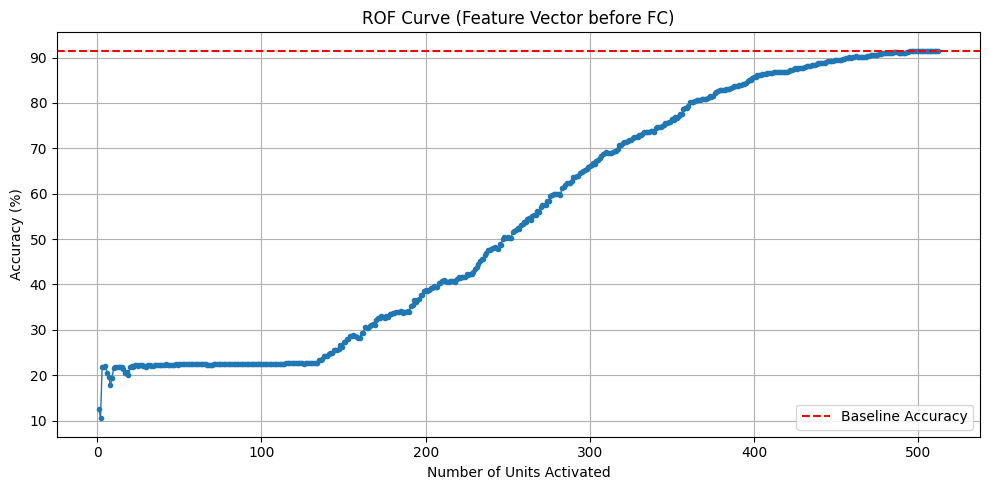

In [45]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ========== Step 1: Define Safe Feature Hook ==========
class FeatureHook:
    def __init__(self):
        self.features = []

    def __call__(self, module, input, output):
        x = output.view(output.size(0), -1)  # Flatten
        self.features.append(x.cpu())

    def clear(self):
        self.features = []

    def get_features(self):
        return torch.cat(self.features, dim=0)


# ========== Step 2: Register Hook on model.avgpool ==========
hook = FeatureHook()
hook_handle = model.avgpool.register_forward_hook(hook)


# ========== Step 3: Run Model to Collect Features ==========
def run_model_and_collect_features(model, dataloader, device, hook):
    model.eval()
    hook.clear()
    labels_all = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            _ = model(images)  # triggers hook
            labels_all.append(labels)

    features = hook.get_features()
    labels = torch.cat(labels_all, dim=0)
    return features, labels


features, labels = run_model_and_collect_features(model, test_loader, device, hook)
print("Feature shape:", features.shape)
print("Labels shape:", labels.shape)

# ========== Step 3: Baseline Accuracy ==========
with torch.no_grad():
    outputs = model.fc(features.to(device))
    preds = outputs.argmax(dim=1)
    base_acc = (preds == labels.to(device)).float().mean().item()
    print(f"\n✅ Baseline Accuracy (all units active): {base_acc * 100:.2f}%")

# ========== Step 4: Compute L1 norms and rank units ==========
l1_norms = features.abs().mean(dim=0)  # [512]
unit_ranking = torch.argsort(l1_norms, descending=True)  # top-K indices

# ========== Step 5: ROF Evaluation Function ==========
def fast_rof_eval(features, labels, model_fc, unit_ranking, top_k_list, device):
    model_fc = model_fc.to(device)
    labels = labels.to(device)
    all_acc = []

    for k in top_k_list:
        # Mask: activate top-k units
        mask = torch.zeros(features.shape[1])
        mask[unit_ranking[:k]] = 1.0
        masked_feats = features * mask  # broadcasting

        masked_feats = masked_feats.to(device)
        with torch.no_grad():
            outputs = model_fc(masked_feats)
            preds = outputs.argmax(dim=1)
            acc = (preds == labels).float().mean().item()
            all_acc.append(acc)

        if k <= 10 or k % 50 == 0 or k == 512:
            print(f"Top {k:3d} units activated | Acc: {acc * 100:.2f}%")

    return all_acc

# ========== Step 6: Run ROF test on all 512 units ==========
top_k_list = list(range(1, 513))
acc_curve = fast_rof_eval(features, labels, model.fc, unit_ranking, top_k_list, device)

# ========== Step 7: Plot the ROF Curve ==========
plt.figure(figsize=(10, 5))
plt.plot(top_k_list, [a * 100 for a in acc_curve], marker='.', linewidth=1)
plt.axhline(base_acc * 100, color='r', linestyle='--', label='Baseline Accuracy')
plt.title("ROF Curve (Feature Vector before FC)")
plt.xlabel("Number of Units Activated")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== Step 8: Cleanup ==========
hook_handle.remove()


Top   1 units activated | Acc: 11.30% | Loss: 2.2784
Top   2 units activated | Acc: 10.70% | Loss: 2.2438
Top   3 units activated | Acc: 10.70% | Loss: 2.2249
Top   4 units activated | Acc: 10.70% | Loss: 2.1982
Top   5 units activated | Acc: 10.70% | Loss: 2.1768
Top   6 units activated | Acc: 10.70% | Loss: 2.1662
Top   7 units activated | Acc: 10.70% | Loss: 2.1543
Top   8 units activated | Acc: 10.80% | Loss: 2.1389
Top   9 units activated | Acc: 10.70% | Loss: 2.1310
Top  10 units activated | Acc: 11.00% | Loss: 2.1182
Top  50 units activated | Acc: 23.30% | Loss: 2.0254
Top 100 units activated | Acc: 25.60% | Loss: 2.0665
Top 150 units activated | Acc: 27.80% | Loss: 2.0554
Top 200 units activated | Acc: 31.90% | Loss: 1.9131
Top 250 units activated | Acc: 40.90% | Loss: 1.6767
Top 300 units activated | Acc: 51.10% | Loss: 1.3480
Top 350 units activated | Acc: 63.60% | Loss: 0.9618
Top 400 units activated | Acc: 73.00% | Loss: 0.6864
Top 450 units activated | Acc: 81.80% | Loss: 

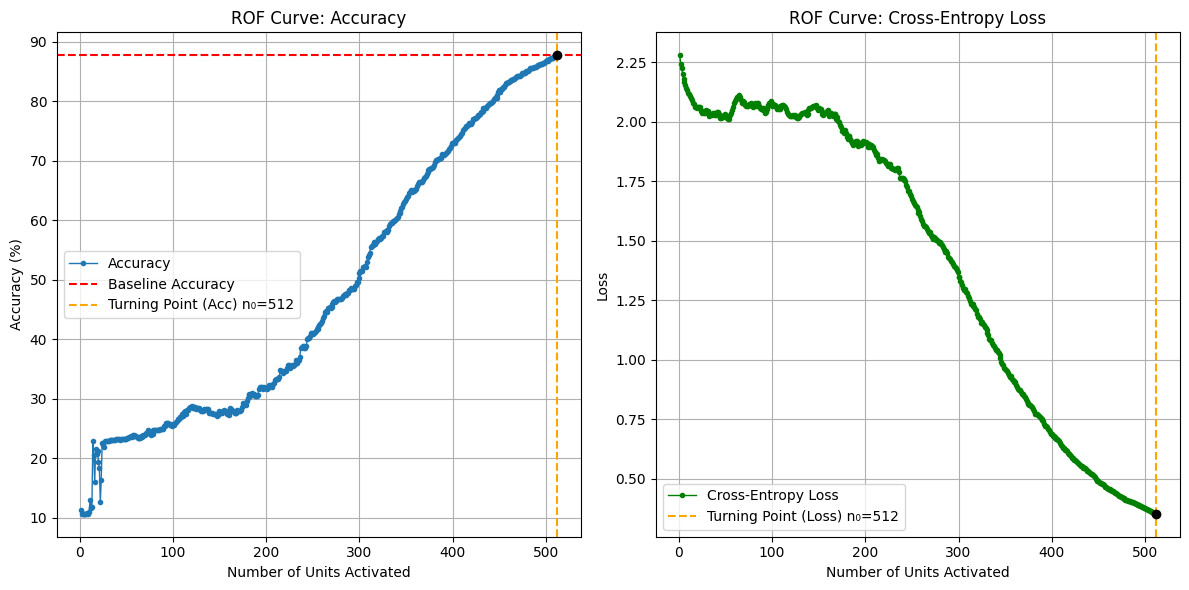

In [71]:
import torch.nn.functional as F

# ========== Step 5 (updated): ROF Evaluation to get accuracy + loss ==========
def fast_rof_eval_with_loss(features, labels, model_fc, unit_ranking, top_k_list, device):
    model_fc = model_fc.to(device)
    labels = labels.to(device)
    all_acc = []
    all_loss = []

    for k in top_k_list:
        mask = torch.zeros(features.shape[1])
        mask[unit_ranking[:k]] = 1.0
        masked_feats = features * mask
        masked_feats = masked_feats.to(device)

        with torch.no_grad():
            outputs = model_fc(masked_feats)
            preds = outputs.argmax(dim=1)
            acc = (preds == labels).float().mean().item()
            loss = F.cross_entropy(outputs, labels).item()

            all_acc.append(acc)
            all_loss.append(loss)

        if k <= 10 or k % 50 == 0 or k == 512:
            print(f"Top {k:3d} units activated | Acc: {acc * 100:.2f}% | Loss: {loss:.4f}")

    return all_acc, all_loss


# ========== Step 6 (updated): Run ROF with loss ==========
top_k_list = list(range(1, 513))
acc_curve, loss_curve = fast_rof_eval_with_loss(features, labels, model.fc, unit_ranking, top_k_list, device)

# ========== Step 7: Find turning points ==========
import numpy as np

# Turning point based on accuracy (max accuracy)
n0_acc = np.argmax(acc_curve)
max_acc = acc_curve[n0_acc]

# Turning point based on loss (min loss)
n0_loss = np.argmin(loss_curve)
min_loss = loss_curve[n0_loss]

print(f"\nTurning point based on accuracy: n0 = {n0_acc + 1}, max accuracy = {max_acc*100:.2f}%")
print(f"Turning point based on loss: n0 = {n0_loss + 1}, min loss = {min_loss:.4f}")

# Highly active units sets
U0_acc = unit_ranking[:n0_acc + 1]
U0_loss = unit_ranking[:n0_loss + 1]

print(f"Number of highly active units by accuracy: {len(U0_acc)}")
print(f"Number of highly active units by loss: {len(U0_loss)}")


# ========== Step 8: Plot ROF Curve with Turning Points ==========
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(top_k_list, [a * 100 for a in acc_curve], marker='.', linewidth=1, label='Accuracy')
plt.axhline(base_acc * 100, color='r', linestyle='--', label='Baseline Accuracy')
plt.axvline(n0_acc + 1, color='orange', linestyle='--', label=f'Turning Point (Acc) n₀={n0_acc + 1}')
plt.scatter(n0_acc + 1, max_acc * 100, color='black', zorder=5)
plt.title("ROF Curve: Accuracy")
plt.xlabel("Number of Units Activated")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(top_k_list, loss_curve, marker='.', linewidth=1, color='green', label='Cross-Entropy Loss')
plt.axvline(n0_loss + 1, color='orange', linestyle='--', label=f'Turning Point (Loss) n₀={n0_loss + 1}')
plt.scatter(n0_loss + 1, min_loss, color='black', zorder=5)
plt.title("ROF Curve: Cross-Entropy Loss")
plt.xlabel("Number of Units Activated")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.savefig("rof_curve_turning_points.pdf", format="pdf", dpi=300)
plt.show()